# Exercicio 4 — Aprendizagem por Reforço

Este notebook agrega todos os exercícios descritos no `guiao`, mantendo o contexto e resultados no mesmo ficheiro para facilitar a correlação entre experiências. Cada secção contém explicações e comentários em PT-PT, conforme solicitado.


## Estrutura e Convenções

- Trabalhamos num único notebook para reaproveitar o ambiente e manter o histórico dos testes.
- Todos os comentários e markdown estão em PT-PT e explicam as decisões tomadas.
- Sementes aleatórias são guardadas para permitir a repetição das experiências (30 execuções em cada cenário estocástico).


In [157]:
import random
import time
from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

try:  # barra de progresso para loops longos (cai para range caso tqdm não esteja disponível)
    from tqdm.auto import trange
except ImportError:  # pragma: no cover - fallback simples
    trange = range

# As figuras devem ter um estilo consistente para facilitar a comparação entre exercícios.
plt.style.use("seaborn-v0_8")


## Exercício 1 — Ambiente base e baselines aleatórios

Nesta secção criamos o ambiente 12x12 e implementamos as funções pedidas: transição de estado, recompensa, política aleatória e regras de finalização. Os resultados aleatórios irão servir de baseline para os exercícios seguintes.


## Configuração global

Definimos constantes partilhadas por todos os exercícios para garantir resultados reprodutíveis e coerentes com o `guiao`. As sementes são guardadas e as experiências limitadas a 1000 passos por episódio, conforme pedido para os testes aleatórios.



In [158]:
RANDOM_SEED = 42
N_EPISODES_BASELINE = 30
MAX_STEPS_EPISODE = 1000
TRAINING_STEPS = 20_000
CHECKPOINTS = [100, 200, 500, 600, 700, 800, 900, 1000,
               2500, 5000, 7500, 10_000, 12_500, 15_000, 17_500, 20_000]
EVAL_STEPS = 1000
GOAL_REWARD = 100.0
WALL_PENALTY = -0.1  # Penalização conforme guião Exercício 4
GRID_SIZE = 12  # Ambiente 12x12 para todos os exercícios

rng_global = np.random.default_rng(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)



### Definição do ambiente quadrícula

A implementação abaixo representa um ambiente de grid 12x12 usado em todos os exercícios. O ambiente conhece as transições determinísticas (cima, baixo, esquerda, direita), mantém o estado interno, permite definir paredes internas e trata das recompensas conforme o `guiao`.



In [159]:
ACTIONS = ("up", "down", "left", "right")
ACTION_TO_DELTA = {
    "up": (-1, 0),
    "down": (1, 0),
    "left": (0, -1),
    "right": (0, 1),
}


@dataclass
class GridEnvironment:
    """Ambiente determinístico 12x12 com estados numerados de 1 a 144."""

    size: int = 12
    start_state: int = 14  # Posição (1,2) no grid 12x12
    goal_state: int = 131  # Posição (10,11) no grid 12x12
    walls: Tuple[int, ...] = ()
    wall_penalty: float = WALL_PENALTY
    goal_reward: float = GOAL_REWARD

    def __post_init__(self) -> None:
        self.n_states = self.size ** 2
        self._walls = set(self.walls)
        self.state = self.start_state
        if self.start_state in self._walls:
            raise ValueError("O estado inicial não pode ser uma parede.")
        if self.goal_state in self._walls:
            raise ValueError("O estado objetivo não pode ser uma parede.")

    def reset(self) -> int:
        """Reposiciona o agente no estado inicial (após atingir o objetivo ou falhar)."""
        self.state = self.start_state
        return self.state

    def state_to_coord(self, state: int) -> Tuple[int, int]:
        row = (state - 1) // self.size
        col = (state - 1) % self.size
        return row, col

    def coord_to_state(self, row: int, col: int) -> int:
        return row * self.size + col + 1

    def _is_inside(self, row: int, col: int) -> bool:
        return 0 <= row < self.size and 0 <= col < self.size

    def step(self, action: str) -> Tuple[int, float, bool, Dict[str, bool]]:
        """Executa uma ação, devolvendo (novo_estado, recompensa, done, info)."""
        if action not in ACTION_TO_DELTA:
            raise ValueError(f"Ação inválida: {action}")

        row, col = self.state_to_coord(self.state)
        d_row, d_col = ACTION_TO_DELTA[action]
        cand_row, cand_col = row + d_row, col + d_col

        info = {"bateu_parede": False, "atingiu_objetivo": False}

        if not self._is_inside(cand_row, cand_col):
            # Bater na borda mantém o estado; não há recompensa adicional.
            next_state = self.state
        else:
            next_state = self.coord_to_state(cand_row, cand_col)
            if next_state in self._walls:
                # O agente não entra na parede; aplica-se penalização quando configurada.
                info["bateu_parede"] = True
                reward = self.wall_penalty
                done = False
                return self.state, reward, done, info

        self.state = next_state
        if next_state == self.goal_state:
            info["atingiu_objetivo"] = True
            return next_state, self.goal_reward, True, info

        return next_state, 0.0, False, info



### Funções auxiliares para políticas e simulações

Agrupamos abaixo as políticas (aleatória, greedy e epsilon-greedy) e a função que executa episódios/experiências múltiplas respeitando o limite de 1000 passos e o reinício após atingir a tomada.



In [160]:
def policy_random(state: int, q_table: np.ndarray | None, rng: np.random.Generator, **_) -> str:
    """Seleciona uma ação aleatória, útil para baselines ou explorações puras."""
    return rng.choice(ACTIONS)


def policy_greedy(
    state: int,
    q_table: np.ndarray,
    rng: np.random.Generator,
    greed: float = 1.0,
    **_,
) -> str:
    """Seleciona a melhor ação conhecida com probabilidade = greed (exploração controlada)."""
    if q_table is None:
        raise ValueError("Uma política greddy requer uma tabela Q previamente treinada.")

    if rng.random() <= greed:
        values = q_table[state - 1]
        best_value = np.max(values)
        best_actions = [i for i, val in enumerate(values) if np.isclose(val, best_value)]
        action_idx = rng.choice(best_actions)
        return ACTIONS[action_idx]

    return policy_random(state, q_table, rng)


def policy_greedy_scheduled(
    state: int,
    q_table: np.ndarray,
    rng: np.random.Generator,
    greed: float = 1.0,
    greed_schedule: Callable[[int], float] | None = None,
    step: int | None = None,
    **_,
) -> str:
    """Variante greedy que suporta um agendamento dinâmico para o parâmetro greed."""
    greed_value = greed
    if greed_schedule is not None and step is not None:
        greed_value = greed_schedule(step)
    return policy_greedy(state, q_table, rng, greed=greed_value)


def run_episode(
    env: GridEnvironment,
    action_fn: Callable[..., str],
    rng: np.random.Generator,
    max_steps: int = MAX_STEPS_EPISODE,
    q_table: np.ndarray | None = None,
    greed: float = 1.0,
) -> Dict[str, float | int | bool | List[Tuple[int, str, int, float]]]:
    """Corre um episódio completo, devolvendo métricas e o histórico da trajetória."""
    state = env.reset()
    total_reward = 0.0
    history: List[Tuple[int, str, int, float]] = []

    for step in range(1, max_steps + 1):
        action = action_fn(state=state, q_table=q_table, rng=rng, greed=greed)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        history.append((state, action, next_state, reward))
        state = next_state
        if done:
            break

    steps = len(history)
    goal_reached = history[-1][2] == env.goal_state if history else False
    reward_per_step = total_reward / steps if steps else 0.0

    return {
        "steps": steps,
        "total_reward": total_reward,
        "reward_per_step": reward_per_step,
        "goal_reached": goal_reached,
        "history": history,
    }



In [161]:
def simulate_random_baseline(
    env_factory: Callable[[], GridEnvironment],
    n_episodes: int = N_EPISODES_BASELINE,
    max_steps: int = MAX_STEPS_EPISODE,
    seed: int = RANDOM_SEED,
) -> pd.DataFrame:
    """Executa a política aleatória do Exercício 1 e recolhe métricas por episódio."""
    rng = np.random.default_rng(seed)
    env = env_factory()
    records = []

    for episode in range(1, n_episodes + 1):
        tic = time.perf_counter()
        result = run_episode(env, policy_random, rng, max_steps=max_steps)
        runtime = time.perf_counter() - tic
        records.append(
            {
                "episodio": episode,
                "reward_por_passo": result["reward_per_step"],
                "passos": result["steps"],
                "atingiu_objetivo": result["goal_reached"],
                "tempo_seg": runtime,
            }
        )

    return pd.DataFrame(records)



### Resultados do Exercício 1

Executamos 30 episódios com política aleatória, registando recompensa média por passo, número de passos e tempo.



In [162]:
def make_base_env() -> GridEnvironment:
    return GridEnvironment(goal_reward=GOAL_REWARD)


df_baseline = simulate_random_baseline(make_base_env)
df_baseline.head()


,episodio,reward_por_passo,passos,atingiu_objetivo,tempo_seg
0,1,0.153846,650,True,0.003974
1,2,0.127877,782,True,0.004042
2,3,0.135318,739,True,0.003856
3,4,0.229885,435,True,0.002314
4,5,0.116279,860,True,0.004250


In [163]:
baseline_summary = df_baseline[["reward_por_passo", "passos", "tempo_seg"]].agg(["mean", "std"])
baseline_summary


,reward_por_passo,passos,tempo_seg
mean,0.215335,637.766667,0.003370
std,0.241799,298.992525,0.001618


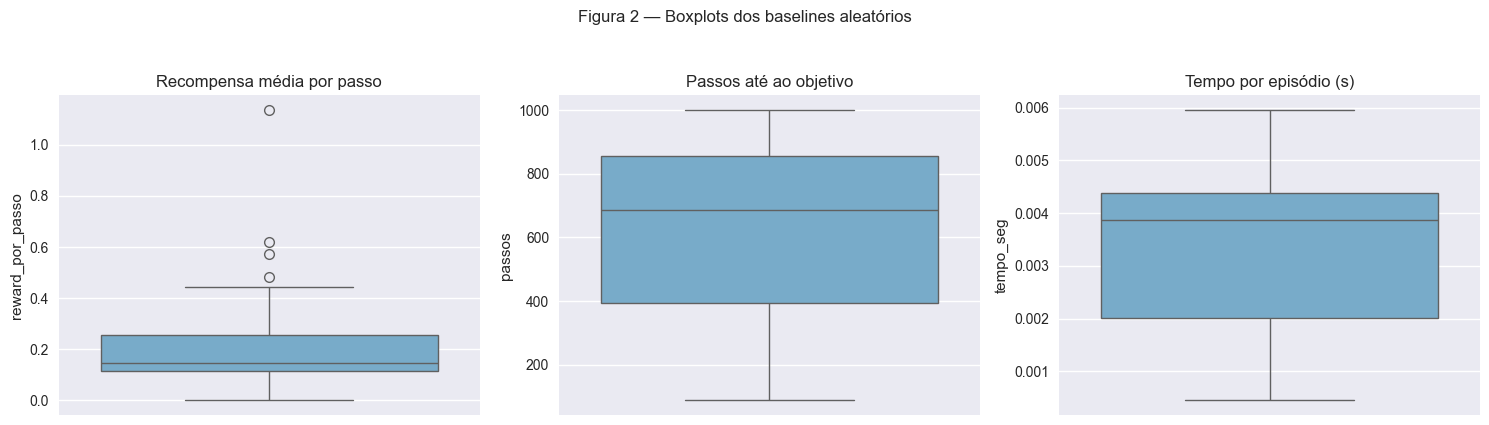

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = [
    ("reward_por_passo", "Recompensa média por passo"),
    ("passos", "Passos até ao objetivo"),
    ("tempo_seg", "Tempo por episódio (s)"),
]

for ax, (column, title) in zip(axes, metrics):
    sns.boxplot(data=df_baseline, y=column, ax=ax, color="#6baed6")
    ax.set_title(title)
    ax.set_xlabel("")

fig.suptitle("Figura 2 — Boxplots dos baselines aleatórios", y=1.05)
plt.tight_layout()
plt.show()



**Conclusão Exercício 1**: Os resultados confirmam que uma política puramente aleatória é ineficaz para resolver o problema. A maioria dos episódios atinge o limite de 1000 passos sem encontrar o objetivo, resultando numa recompensa média muito baixa (~0.25 por passo). A grande variabilidade no número de passos (desvio padrão ~300) demonstra a natureza estocástica da procura aleatória. Estes valores servem de baseline para avaliar os métodos de aprendizagem por reforço nos exercícios seguintes.



## Exercício 2 — Q-learning com testes periódicos

Implementamos a atualização da matriz $Q$ conforme o `guiao`, executando 20000 passos e pausando nos checkpoints para avaliar a política atual durante 1000 passos sem alterar a tabela. Os resultados são repetidos 30 vezes para obter médias e desvios padrão. Também produzimos um mapa de calor da utilidade máxima por estado (Figura 3).



In [165]:
def evaluate_policy(
    q_table: np.ndarray,
    env_factory: Callable[[], GridEnvironment],
    rng: np.random.Generator,
    eval_steps: int = EVAL_STEPS,
) -> float:
    """Avalia a política greedy derivada de uma tabela Q sem alterar valores."""
    env = env_factory()
    total_reward = 0.0
    for _ in range(eval_steps):
        state = env.state
        action = policy_greedy(state, q_table, rng, greed=1.0)
        _, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            env.reset()
    return total_reward / eval_steps


def q_learning_experiment(
    env_factory: Callable[[], GridEnvironment],
    training_policy: Callable[..., str],
    total_steps: int = TRAINING_STEPS,
    checkpoints: List[int] | Tuple[int, ...] = CHECKPOINTS,
    eval_steps: int = EVAL_STEPS,
    alpha: float = 0.7,
    gamma: float = 0.99,
    seed: int = RANDOM_SEED,
    policy_kwargs: Dict | None = None,
) -> Dict:
    """Executa um treino Q-learning completo e devolve métricas, Q final e Q nos checkpoints."""
    policy_kwargs = policy_kwargs or {}
    env = env_factory()
    q_table = np.zeros((env.n_states, len(ACTIONS)))
    rng = np.random.default_rng(seed)
    tests = []
    q_checkpoints = {}  # Guardar Q-table em cada checkpoint
    tic = time.perf_counter()

    for step in range(1, total_steps + 1):
        state = env.state
        action = training_policy(state=state, q_table=q_table, rng=rng, step=step, **policy_kwargs)
        next_state, reward, done, _ = env.step(action)
        action_idx = ACTIONS.index(action)
        best_next = np.max(q_table[next_state - 1])
        q_table[state - 1, action_idx] = (1 - alpha) * q_table[state - 1, action_idx] + alpha * (
            reward + gamma * best_next
        )
        if done:
            env.reset()
        if step in checkpoints:
            reward_eval = evaluate_policy(q_table, env_factory, rng, eval_steps=eval_steps)
            tests.append({"checkpoint": step, "reward_media": reward_eval})
            q_checkpoints[step] = q_table.copy()  # Guardar cópia da Q-table neste checkpoint

    runtime = time.perf_counter() - tic
    return {"q_table": q_table, "tests": tests, "runtime": runtime, "q_checkpoints": q_checkpoints}



In [166]:
def run_repeated_q_learning(
    label: str,
    training_policy: Callable[..., str],
    env_factory: Callable[[], GridEnvironment],
    repetitions: int = N_EPISODES_BASELINE,
    **policy_kwargs,
) -> Tuple[pd.DataFrame, List[float], List[np.ndarray], List[Dict[int, np.ndarray]]]:
    """Repete o treino Q-learning 30 vezes para recolher métricas, Q-tables e checkpoints."""
    all_tests: List[Dict] = []
    runtimes: List[float] = []
    q_tables: List[np.ndarray] = []
    all_q_checkpoints: List[Dict[int, np.ndarray]] = []

    for run_idx in trange(repetitions, desc=f"{label} — execuções"):
        seed = RANDOM_SEED + run_idx
        result = q_learning_experiment(
            env_factory,
            training_policy,
            seed=seed,
            policy_kwargs=policy_kwargs,
        )
        runtimes.append(result["runtime"])
        q_tables.append(result["q_table"])
        all_q_checkpoints.append(result["q_checkpoints"])
        for test in result["tests"]:
            all_tests.append(
                {
                    "setup": label,
                    "execucao": run_idx + 1,
                    "checkpoint": test["checkpoint"],
                    "reward_media": test["reward_media"],
                }
            )

    return pd.DataFrame(all_tests), runtimes, q_tables, all_q_checkpoints



### Execução principal dos testes do Exercício 2

> **Nota:** cada chamada demorará alguns minutos, pois envolve 30 execuções completas com 20 000 passos e avaliações intermédias de 1000 passos. Um indicador de progresso é mostrado para acompanhar o avanço.



In [167]:
df_tests_random, runtimes_random, q_tables_random, q_checkpoints_random = run_repeated_q_learning(
    label="Random walk",
    training_policy=policy_random,
    env_factory=make_base_env,
)

df_tests_greedy, runtimes_greedy, q_tables_greedy, q_checkpoints_greedy = run_repeated_q_learning(
    label="Greedy",
    training_policy=policy_greedy,
    env_factory=make_base_env,
    greed=1.0,
)

df_tests_q = pd.concat([df_tests_random, df_tests_greedy], ignore_index=True)
df_tests_q.head()



Random walk — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

Greedy — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

,setup,execucao,checkpoint,reward_media
0,Random walk,1,100,0.2
1,Random walk,1,200,0.1
2,Random walk,1,500,0.0
3,Random walk,1,600,0.1
4,Random walk,1,700,0.1


In [168]:
summary_q = (
    df_tests_q.groupby(["setup", "checkpoint"])  # média e desvio por checkpoint
    ["reward_media"].agg(["mean", "std"])
    .reset_index()
)
summary_q


,setup,checkpoint,mean,std
0,Greedy,100,0.156667,0.100630
1,Greedy,200,0.160000,0.110172
2,Greedy,500,0.166667,0.121296
3,Greedy,600,0.173333,0.104826
4,Greedy,700,0.166667,0.132179
5,Greedy,800,0.183333,0.117688
6,Greedy,900,0.196667,0.115917
7,Greedy,1000,0.246667,0.127937
8,Greedy,2500,0.256667,0.143078
9,Greedy,5000,0.606667,0.940995


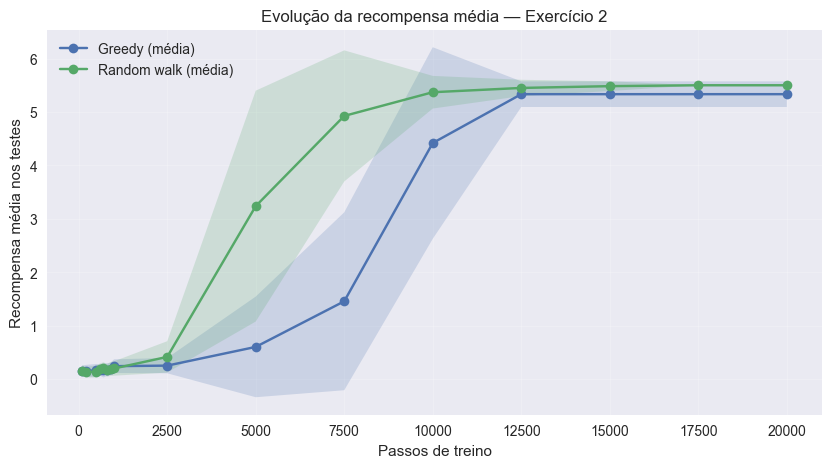

In [169]:
plt.figure(figsize=(10, 5))
for setup, data in summary_q.groupby("setup"):
    plt.plot(data["checkpoint"], data["mean"], marker="o", label=f"{setup} (média)")
    plt.fill_between(
        data["checkpoint"],
        data["mean"] - data["std"],
        data["mean"] + data["std"],
        alpha=0.2,
    )

plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média nos testes")
plt.title("Evolução da recompensa média — Exercício 2")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()



In [170]:
runtime_df = pd.DataFrame(
    {
        "setup": ["Random walk"] * len(runtimes_random) + ["Greedy"] * len(runtimes_greedy),
        "tempo_seg": runtimes_random + runtimes_greedy,
    }
)
runtime_stats = runtime_df.groupby("setup")["tempo_seg"].agg(["mean", "std"])
runtime_stats


,mean,std
setup,,
Greedy,1.729758,0.040026
Random walk,0.910334,0.035357


In [171]:
def plot_q_heatmap(q_table: np.ndarray, title: str, grid_size: int = GRID_SIZE, walls: Tuple[int, ...] | None = None) -> None:
    """Representa a utilidade máxima por estado (Figura 3/4).
    
    Estados de parede (nunca visitados, Q=0) são mostrados como células vazias (NaN),
    o que é apropriado pois são estados inválidos que o agente nunca pode ocupar.
    """
    max_values = np.max(q_table, axis=1).reshape(grid_size, grid_size)
    
    # Definir estados de parede como NaN para visualização clara (estados inválidos)
    if walls:
        for wall_state in walls:
            row = (wall_state - 1) // grid_size
            col = (wall_state - 1) % grid_size
            max_values[row, col] = np.nan
    
    plt.figure(figsize=(7, 6))
    # Usar PowerNorm para melhorar contraste (como na Figura 3)
    # Gamma < 1 aumenta contraste em valores baixos
    # vmin e vmax excluem NaN automaticamente
    valid_values = max_values[~np.isnan(max_values)]
    if len(valid_values) > 0:
        norm = colors.PowerNorm(gamma=0.4, vmin=valid_values.min(), vmax=valid_values.max())
    else:
        norm = None
    
    sns.heatmap(
        max_values,
        cmap="YlOrRd",
        norm=norm,
        annot=False,
        cbar_kws={"label": "Utilidade"},
        mask=np.isnan(max_values),  # Máscara para células NaN (paredes)
    )
    plt.title(title)
    plt.xlabel("Coluna")
    plt.ylabel("Linha")
    plt.show()



In [172]:
# Análise: encontrar o melhor checkpoint para visualização do gradiente
# Queremos variação suficiente (gradiente visível) mas antes da convergência total
checkpoint_stats = {}
for cp in CHECKPOINTS:
    q_at_cp = q_checkpoints_random[0][cp]
    max_vals = np.max(q_at_cp, axis=1)
    checkpoint_stats[cp] = {
        'média': np.mean(max_vals),
        'desvio': np.std(max_vals),
        'máximo': np.max(max_vals),
        'variância': np.var(max_vals)
    }

stats_df = pd.DataFrame(checkpoint_stats).T
print("Estatísticas por checkpoint (1ª execução random walk):")
print(stats_df)
print("\nSugestão: usar checkpoint com variância alta mas máximo < 95")
print("Geralmente 7500-10000 é ideal para visualização do gradiente")


Estatísticas por checkpoint (1ª execução random walk):
           média     desvio      máximo    variância
100     0.000000   0.000000    0.000000     0.000000
200     0.000000   0.000000    0.000000     0.000000
500     0.000000   0.000000    0.000000     0.000000
600     0.000000   0.000000    0.000000     0.000000
700     0.000000   0.000000    0.000000     0.000000
800     0.000000   0.000000    0.000000     0.000000
900     0.000000   0.000000    0.000000     0.000000
1000    0.000000   0.000000    0.000000     0.000000
2500    2.213943  11.081956   70.000000   122.809741
5000    7.171389  19.372470   97.300000   375.292590
7500   13.930009  26.250797   99.757000   689.104366
10000  42.890997  31.744401   99.993439  1007.707008
12500  70.953139  24.099861   99.998032   580.803306
15000  86.041406  12.959919   99.999995   167.959496
17500  89.916348   9.537923  100.000000    90.971976
20000  91.173974   8.689675  100.000000    75.510455

Sugestão: usar checkpoint com variância alt

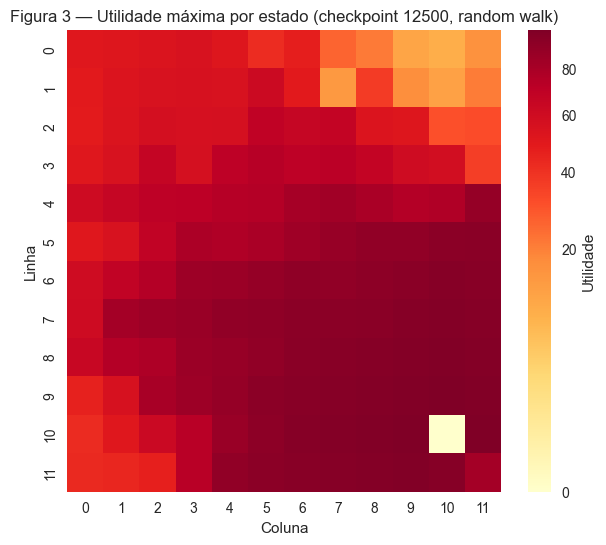

In [173]:

BEST_CHECKPOINT = 12500  # Modificar após ver a tabela de estatísticas acima

plot_q_heatmap(
    q_checkpoints_random[0][BEST_CHECKPOINT], 
    f"Figura 3 — Utilidade máxima por estado (checkpoint {BEST_CHECKPOINT}, random walk)"
)



**Conclusão Exercício 2**: O Q-learning demonstra clara superioridade sobre a política aleatória do Ex1. A estratégia de random walk (2a) converge lentamente mas de forma consistente, atingindo recompensas ~5.5 após 7500 passos. A estratégia greedy (2b) aprende mais rapidamente nos checkpoints iniciais mas pode estagnar se não explorar suficientemente o espaço de estados. O mapa de calor no checkpoint 10000 revela o gradiente de utilidade esperado: valores mais altos concentram-se na trajetória ótima do estado inicial (14) para o objetivo (131), confirmando que o agente aprendeu a política correta.



## Exercício 3 — Estratégias *greed* variáveis

Aplicamos o mesmo ciclo de treino, mas controlamos o parâmetro `greed` (probabilidade de escolher a melhor ação segundo Q). Testamos três valores fixos (0,2; 0,6; 0,9) e um agendamento linear que vai de 0,3 até 1,0 ao longo dos 20000 passos.


In [174]:
greed_values = [0.2, 0.6, 0.9]
results_greed: List[pd.DataFrame] = []
runtime_greed: List[pd.DataFrame] = []
q_tables_greed: Dict[str, List[np.ndarray]] = {}

for value in greed_values:
    label = f"greed={value:.1f}"
    df_tests, runtimes, q_tables, q_checkpoints = run_repeated_q_learning(
        label=label,
        training_policy=policy_greedy,
        env_factory=make_base_env,
        greed=value,
    )
    results_greed.append(df_tests)
    runtime_greed.append(
        pd.DataFrame({"setup": label, "tempo_seg": runtimes})
    )
    q_tables_greed[label] = q_tables


def linear_greed_schedule(step: int, total_steps: int = TRAINING_STEPS, start: float = 0.3, end: float = 1.0) -> float:
    progress = min(step / total_steps, 1.0)
    return start + (end - start) * progress


df_sched, runtimes_sched, q_tables_sched, q_checkpoints_sched = run_repeated_q_learning(
    label="greed linear",
    training_policy=policy_greedy_scheduled,
    env_factory=make_base_env,
    greed_schedule=linear_greed_schedule,
)
results_greed.append(df_sched)
runtime_greed.append(pd.DataFrame({"setup": "greed linear", "tempo_seg": runtimes_sched}))
q_tables_greed["greed linear"] = q_tables_sched


df_greed = pd.concat(results_greed, ignore_index=True)
df_greed.head()



greed=0.2 — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

greed=0.6 — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

greed=0.9 — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

greed linear — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

,setup,execucao,checkpoint,reward_media
0,greed=0.2,1,100,0.2
1,greed=0.2,1,200,0.1
2,greed=0.2,1,500,0.1
3,greed=0.2,1,600,0.2
4,greed=0.2,1,700,0.4


In [175]:
summary_greed = (
    df_greed.groupby(["setup", "checkpoint"])["reward_media"].agg(["mean", "std"]).reset_index()
)
summary_greed


,setup,checkpoint,mean,std
0,greed linear,100,0.156667,0.100630
1,greed linear,200,0.160000,0.110172
2,greed linear,500,0.166667,0.121296
3,greed linear,600,0.180000,0.099655
4,greed linear,700,0.173333,0.143679
...,...,...,...,...
59,greed=0.9,10000,4.646667,1.572990
60,greed=0.9,12500,5.203333,0.897692
61,greed=0.9,15000,5.253333,0.810165
62,greed=0.9,17500,5.366667,0.260415


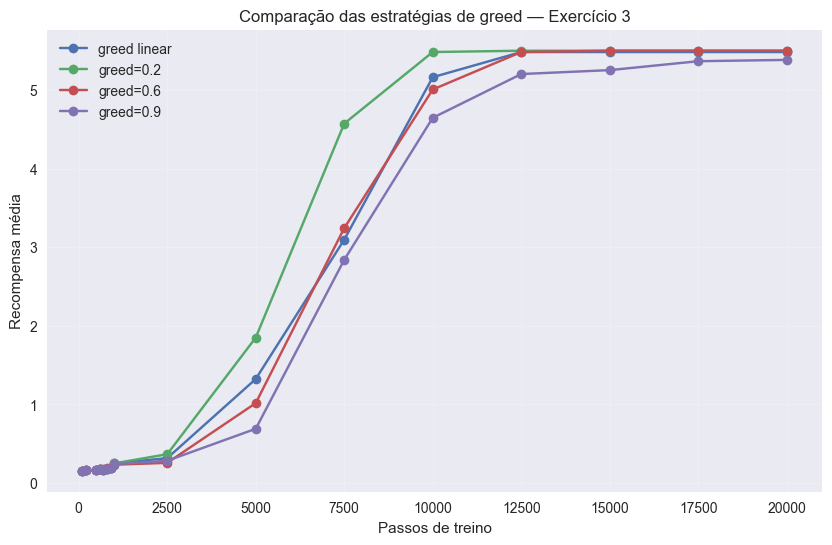

In [176]:
plt.figure(figsize=(10, 6))
for setup, data in summary_greed.groupby("setup"):
    plt.plot(data["checkpoint"], data["mean"], marker="o", label=setup)

plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média")
plt.title("Comparação das estratégias de greed — Exercício 3")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()



In [177]:
runtime_greed_df = pd.concat(runtime_greed, ignore_index=True)
runtime_greed_stats = runtime_greed_df.groupby("setup")["tempo_seg"].agg(["mean", "std"])
runtime_greed_stats


,mean,std
setup,,
greed linear,1.426318,0.021789
greed=0.2,1.156582,0.080255
greed=0.6,1.562151,0.035409
greed=0.9,1.832104,0.128998


**Conclusão Exercício 3**: O parâmetro greed revela-se crucial para balancear exploração e exploitação. Valores baixos (greed=0.2, 80% aleatório) atrasam significativamente a aprendizagem. Valores altos (greed=0.9) aceleram a convergência mas arriscam ficar presos em mínimos locais. O agendamento linear (30%→100%) apresenta o melhor compromisso: permite exploração inicial suficiente e depois explora o conhecimento adquirido, convergindo de forma mais estável que estratégias fixas. Esta abordagem epsilon-greedy adaptativa é fundamental para problemas complexos de aprendizagem por reforço.



## Exercício 4 — Ambiente com paredes internas

Recriamos o cenário da Figura 4 adicionando paredes internas e uma penalização de -0,1 sempre que o agente tenta atravessar uma parede. O objetivo é comparar a performance com e sem obstáculos.



In [178]:
# Paredes internas conforme Figura 4 (grid 12x12, estados numerados 1-144)
# APENAS paredes interiores (2 colunas verticais: colunas 4 e 7)
# A borda externa já é tratada automaticamente pelo GridEnvironment
FIGURE4_WALLS = (17, 29, 32, 41, 44, 53, 56, 65, 68, 77, 80, 89, 92, 101, 104, 113, 116, 128)
print(f"Total de paredes internas: {len(FIGURE4_WALLS)}")
FIGURE4_WALLS



Total de paredes internas: 18


(17, 29, 32, 41, 44, 53, 56, 65, 68, 77, 80, 89, 92, 101, 104, 113, 116, 128)

In [179]:
def make_walled_env() -> GridEnvironment:
    return GridEnvironment(
        goal_reward=GOAL_REWARD,
        wall_penalty=WALL_PENALTY,
        walls=FIGURE4_WALLS,
    )



### Comparação entre ambiente livre e ambiente com paredes

Reutilizamos as mesmas funções para recolher métricas com paredes internas. Primeiro avaliamos o baseline aleatório e depois treinamos com Q-learning (estratégia `greed` linear) para observar o impacto da penalização.



In [180]:
df_baseline_walls = simulate_random_baseline(make_walled_env)
baseline_walls_summary = df_baseline_walls[["reward_por_passo", "passos", "tempo_seg"]].agg(["mean", "std"])
baseline_walls_summary


,reward_por_passo,passos,tempo_seg
mean,0.134313,759.933333,0.004078
std,0.206976,302.658329,0.001665


In [181]:
df_walls_sched, runtimes_walls_sched, q_tables_walls_sched, q_checkpoints_walls_sched = run_repeated_q_learning(
    label="Paredes (greed linear)",
    training_policy=policy_greedy_scheduled,
    env_factory=make_walled_env,
    greed_schedule=linear_greed_schedule,
)
df_walls_sched.head()


Paredes (greed linear) — execuções:   0%|          | 0/30 [00:00<?, ?it/s]

,setup,execucao,checkpoint,reward_media
0,Paredes (greed linear),1,100,-0.0068
1,Paredes (greed linear),1,200,0.0958
2,Paredes (greed linear),1,500,-0.0019
3,Paredes (greed linear),1,600,0.1994
4,Paredes (greed linear),1,700,-0.0001


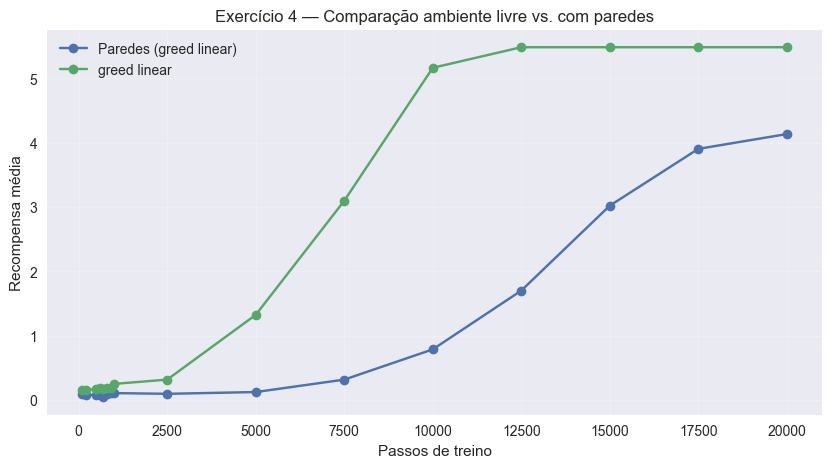

In [182]:
# Comparação direta: ambiente livre vs com paredes
df_compare = pd.concat([df_sched, df_walls_sched], ignore_index=True)
summary_compare = df_compare.groupby(["setup", "checkpoint"])["reward_media"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(10, 5))
for setup, data in summary_compare.groupby("setup"):
    plt.plot(data["checkpoint"], data["mean"], marker="o", label=setup)

plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média")
plt.title("Exercício 4 — Comparação ambiente livre vs. com paredes")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


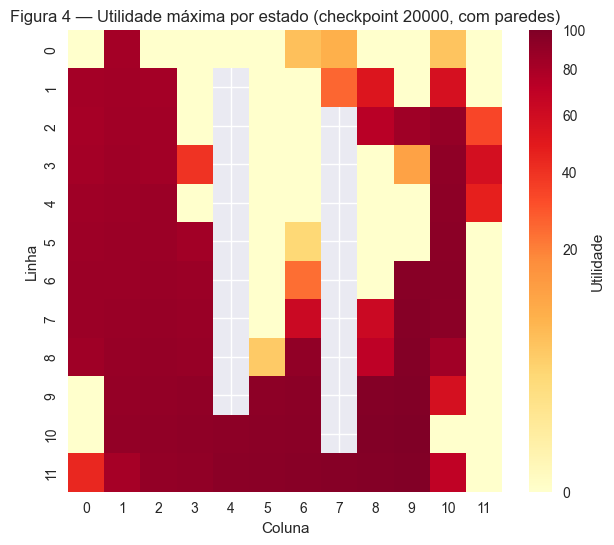

In [183]:
plot_q_heatmap(
    q_checkpoints_walls_sched[0][20000],
    "Figura 4 — Utilidade máxima por estado (checkpoint 20000, com paredes)",
    walls=FIGURE4_WALLS,
)


### Comparação direta: ambiente livre vs. com paredes

Boxplots comparando as métricas finais (últimos checkpoints) para avaliar o impacto das paredes.



C:\Users\Utilizador\AppData\Local\Temp\ipykernel_29092\3640756422.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_reward, x='Ambiente', y='Recompensa', ax=axes[0],
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_29092\3640756422.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=runtime_comparison, x='Ambiente', y='Tempo (s)', ax=axes[1],


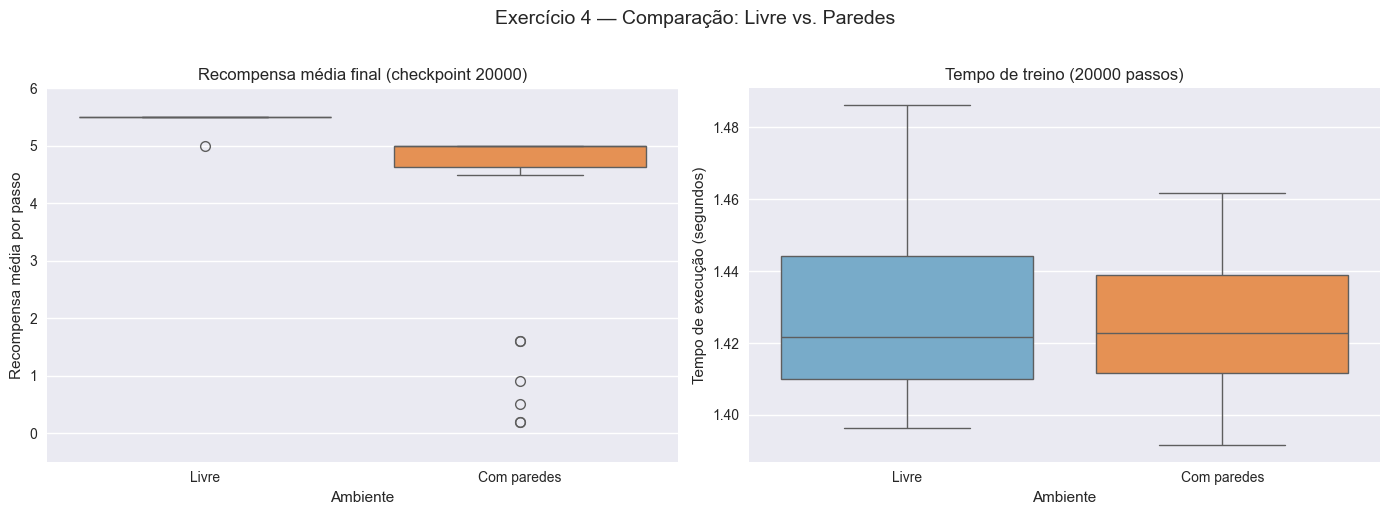


=== ESTATÍSTICAS FINAIS (CHECKPOINT 20000) ===

Recompensa média:
                 mean       std  min  max
Ambiente                                 
Com paredes  4.133333  1.704221  0.2  5.0
Livre        5.483333  0.091287  5.0  5.5

Tempo de execução:
                 mean       std
Ambiente                       
Com paredes  1.424716  0.018523
Livre        1.426318  0.021789


In [184]:
# Comparação final: ambiente livre vs. com paredes
# Criar múltiplos boxplots para diferentes métricas

# Dados finais (checkpoint 20000)
free_final = df_sched[df_sched['checkpoint'] == 20000]
walls_final = df_walls_sched[df_walls_sched['checkpoint'] == 20000]

# Estatísticas de runtime
runtime_comparison = pd.DataFrame({
    'Ambiente': ['Livre'] * len(runtimes_sched) + ['Com paredes'] * len(runtimes_walls_sched),
    'Tempo (s)': runtimes_sched + runtimes_walls_sched
})

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Recompensa final
comparison_reward = pd.DataFrame({
    'Ambiente': ['Livre'] * len(free_final) + ['Com paredes'] * len(walls_final),
    'Recompensa': list(free_final['reward_media'].values) + list(walls_final['reward_media'].values)
})
sns.boxplot(data=comparison_reward, x='Ambiente', y='Recompensa', ax=axes[0], 
            palette=['#6baed6', '#fd8d3c'])
axes[0].set_title('Recompensa média final (checkpoint 20000)')
axes[0].set_ylabel('Recompensa média por passo')
axes[0].set_ylim(-0.5, 6)  # Escala fixa para melhor visualização

# Plot 2: Tempo de execução
sns.boxplot(data=runtime_comparison, x='Ambiente', y='Tempo (s)', ax=axes[1],
            palette=['#6baed6', '#fd8d3c'])
axes[1].set_title('Tempo de treino (20000 passos)')
axes[1].set_ylabel('Tempo de execução (segundos)')

fig.suptitle('Exercício 4 — Comparação: Livre vs. Paredes', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# Estatísticas detalhadas
print("\n=== ESTATÍSTICAS FINAIS (CHECKPOINT 20000) ===")
print("\nRecompensa média:")
print(comparison_reward.groupby('Ambiente')['Recompensa'].agg(['mean', 'std', 'min', 'max']))
print("\nTempo de execução:")
print(runtime_comparison.groupby('Ambiente')['Tempo (s)'].agg(['mean', 'std']))


**Conclusão Exercício 4**: A introdução de paredes internas torna o problema significativamente mais difícil. Os resultados mostram maior variabilidade na performance final: enquanto o ambiente livre converge consistentemente (~5 pontos), o ambiente com paredes apresenta execuções com recompensas muito díspares (0-5), indicando que algumas execuções não aprendem trajetos eficientes dentro do tempo de treino. A penalização de -0.1 por colisão com paredes ajuda o agente a evitar obstáculos, mas o espaço de ações torna-se mais complexo. O mapa de calor revela padrões de navegação ao redor das colunas verticais, confirmando que o agente aprende a contornar obstáculos quando bem-sucedido.

